In [1]:


%matplotlib inline

##THIS IS FOR ACCESSING THE CONCORDE TSP SOLVER
from subprocess import Popen

import os
class tsp:
    def __init__(self, points=None):
        self.points = points if points else []
    def solve(self, filename='_tmp_'):
        with open('%s.dat' % filename, 'w') as fp:
            fp.write('TYPE : TSP\nDIMENSION : %d\n' % len(self.points))
            fp.write('EDGE_WEIGHT_TYPE : GEO\nNODE_COORD_SECTION\n')
            for i, (x, y) in enumerate(self.points):
                fp.write('%d %g %g\n' % (i, x, y))
            fp.write('EOF\n')
        prc = Popen('./concorde   -m %s.dat' % filename, shell=True)
        prc.wait()
        with open('%s.sol' % filename) as fp:
            ll = (''.join(fp)).split()
        self.result = [int(s) for s in ll[1:]]
        for s in ('%s.dat', '%s.sol'): os.remove(s % filename)

            
            

In [2]:
##THIS I FOR ACCESSING THE CONCORDE TSP SOLVER BZCKUP,SWITCHING TO GEO
#from subprocess import Popen
#import os
#class tsp:
#    def __init__(self, points=None):
#        self.points = points if points else []
#    def solve(self, filename='_tmp_'):
#        with open('%s.dat' % filename, 'w') as fp:
#            fp.write('TYPE : TSP\nDIMENSION : %d\n' % len(self.points))
#            fp.write('EDGE_WEIGHT_TYPE : EUC_2D\nNODE_COORD_SECTION\n')
#            for i, (x, y) in enumerate(self.points):
#                fp.write('%d %g %g\n' % (i, x, y))
#            fp.write('EOF\n')
#        prc = Popen('./concorde -m  %s.dat' % filename, shell=True)
#        prc.wait()
#        with open('%s.sol' % filename) as fp:
#            ll = (''.join(fp)).split()
#        self.result = [int(s) for s in ll[1:]]
#        for s in ('%s.dat', '%s.sol'): os.remove(s % filename)

In [3]:
import geopy
import pickle
import json
import pymongo
from geopy.distance import vincenty
#import musicbrainzngs
import arrow
from datetime import datetime
from pymongo import MongoClient
from collections import defaultdict
from dateutil import parser
from slugify import slugify
import math
from numbers import Number

# setup mongo
client = MongoClient()
db = client["bandstour"]
bandsintown =  db["bandsintown"]

# date parsing
DATETIME_FORMAT = '%Y-%m-%dT%H:%M:%S'
DATETIME_FORMAT_FOR_MSBNZ ='%Y-%m-%d'

#retrieve trip coords for each artist
dict_coords={}

import numpy as np
from matplotlib import pyplot as plt


In [10]:
#INITIALIZE

final_embeddings=[]
totalDists=0
totalOptDists=0
totalOptDistsMin=0
#for artist in db.minedArtists.find({ 'name' : 'David Guetta' }) :
#for artist in db.minedArtists.find({ 'name' : 'Vokab Kompany' }) :
#for artist in db.minedArtists.find({ 'name' : 'Ural Kosaken Chor' }) :
#for artist in db.minedArtists.find({ 'name' : 'Leo Kottke' }) :
#for artist in db.minedArtists.find({ 'name' : 'Björk' }) :
#for artist in db.minedArtists.find({ 'name' : 'Deerhoof' }) :
#for artist in db.minedArtists.find({ 'name' : 'Legends' }) :
#for artist in db.minedArtists.find({ 'name' : 'Laidback Luke' }) :
#for artist in db.minedArtists.find({ 'name' : 'Andy Moor' }) :
#for artist in db.minedArtists.find({ 'name' : 'Mia' }) :
#for artist in db.minedArtists.find({ 'name' : 'Dead Kennedys' }) :
#for artist in db.minedArtists.find({ 'name' : 'House of Pain' }) :
for artist in db.minedArtists.find(no_cursor_timeout=True) :
#LOOP THROUGH ALL ARTISTS IN BASE AND CALCULATE OPTIMIZED PARAMETER
 if os.path.exists("./tour_miner_NEW/"+slugify(artist["name"]+str(artist["mbid"]))+".obj")==True:
        print "SKIPPED",artist["name"]
        #print slugify(artist["name"])
        with open("./tour_miner_NEW/"+slugify(artist["name"]+str(artist["mbid"]))+".obj", 'rb') as handle:
          temp= pickle.load( handle)
        #print temp
        tmppp =0
        
        totalArtistTourDist=0
        totalArtistOptTourDist=0
        totalArtistTourDist=temp["totalArtistTourDist"]
        totalArtistOptTourDist=temp["totalArtistOptTourDist"]
        
        totalDists+=totalArtistTourDist
        totalOptDists+=totalArtistOptTourDist
        if float(totalArtistTourDist) <= float(totalArtistOptTourDist)      :  
            tmppp=float(totalArtistTourDist)
        else:
            tmppp=float(totalArtistOptTourDist)
        totalOptDistsMin+=tmppp
        #print totalArtistTourDist," / ",totalArtistOptTourDist
        #print totalDists," / ",totalOptDists," / ",totalOptDistsMin," / ",tmppp
        
        #pass
 else:
    

    results={}
    tourindice=0
    results["name"]=artist["name"]
    #print artist["name"]
    totalArtistTourDist=0
    totalArtistOptTourDist=0
    for tour in artist["tours"]:
        #print tour["gigs"][0]["datetime"].year
        #print tour["gigs"][-1]["datetime"].year
        #print int(math.ceil(len(tour["gigs"])/2))
        tourCoords= []
        tourdist=0
        tourdistOpt=0
        tourdistOpt2=0
        tourdistOpt3=0
        tourLength=0
        tourYear=0
        tourYearStart=0
        tourYearEnd=0
        tourYearMid=0
        t=0
        #print len(tour["tourCoords"])
        if len(tour["tourCoords"])>2:
         tourLength=int(math.ceil(len(tour["gigs"])))
         if tourLength > 365:
                print tourLength
         if tourLength>0:
            tourYearStart=tour["gigs"][0]["datetime"].year
            tourYearEnd=tour["gigs"][-1]["datetime"].year
            if tourYearStart == tourYearEnd :
                tourYear= tourYearStart
            else:
                tourYearMid= tourYearEnd=tour["gigs"][int(math.ceil(len(tour["gigs"])/2))]["datetime"].year
                if tourYearStart == tourYearMid :
                    tourYear= tourYearStart
                else:
                    tourYear= tourYearEnd
            
            tourindice+=1
            tourCoords=[tuple(tourCoord) for tourCoord in tour["tourCoords"]]
            #print tourCoords
            ###RERUN OPT,PICKING BETTER SOLUTION
            t=tsp(tourCoords)
            t.solve()
            #print "here"

            #print t.result
            #print t.points
            #print "long",len (t.result)
            i = 0
            while i < len (t.result)-1:
                res=t.result[i]
                res2=t.result[i+1]
                #print vincenty(t.points[res],t.points[res2]).kilometers
                tourdistOpt= tourdistOpt + vincenty(t.points[res],t.points[res2]).kilometers
                
                
                i+=1
            
            j = 0
            while j < len (tourCoords)-1:
                
                #print vincenty(t.points[res],t.points[res2]).kilometers
                tourdist= tourdist + vincenty(tourCoords[j],tourCoords[j+1]).kilometers
                j+=1
            
            #print "DEFAULT TOUR DIST",tourdist
            #print "TOURDISTOPTIMIZED",tourdistOpt
            totalArtistTourDist+=tourdist
            totalArtistOptTourDist+=tourdistOpt
            results[tourindice]={'tourdist':tourdist,'tourdistOpt':tourdistOpt,'tourLength' : tourLength , 'tourYear': tourYear}
    #print results
    tourInd=0
    resultsYears={}
    for tourInd in results:
     #print tourInd
        #if tourInd != 'name ':
     if isinstance(tourInd, Number):
        """"reduce dataset to its relevant years !!!! 
        1990 / Nb de groupes comptabilisés cette année / 1
1991 / Nb de groupes comptabilisés cette année / 1
1992 / Nb de groupes comptabilisés cette année / 3
1993 / Nb de groupes comptabilisés cette année / 1
1994 / Nb de groupes comptabilisés cette année / 2
1995 / Nb de groupes comptabilisés cette année / 2
1996 / Nb de groupes comptabilisés cette année / 2
1997 / Nb de groupes comptabilisés cette année / 8
1998 / Nb de groupes comptabilisés cette année / 2
1999 / Nb de groupes comptabilisés cette année / 15
2000 / Nb de groupes comptabilisés cette année / 4
2001 / Nb de groupes comptabilisés cette année / 1
2002 / Nb de groupes comptabilisés cette année / 3
2003 / Nb de groupes comptabilisés cette année / 7
2004 / Nb de groupes comptabilisés cette année / 10
2005 / Nb de groupes comptabilisés cette année / 17
2006 / Nb de groupes comptabilisés cette année / 22
2007 / Nb de groupes comptabilisés cette année / 2719
2008 / Nb de groupes comptabilisés cette année / 4101
2009 / Nb de groupes comptabilisés cette année / 5447
2010 / Nb de groupes comptabilisés cette année / 7083
2011 / Nb de groupes comptabilisés cette année / 6965
2012 / Nb de groupes comptabilisés cette année / 11048
2013 / Nb de groupes comptabilisés cette année / 13451
2014 / Nb de groupes comptabilisés cette année / 16331
2015 / Nb de groupes comptabilisés cette année / 20790
2016 / Nb de groupes comptabilisés cette année / 25322
2017 / Nb de groupes comptabilisés cette année / 25302
2018 / Nb de groupes comptabilisés cette année / 475
2019 / Nb de groupes comptabilisés cette année / 1)
          if results[tourInd]['tourYear'] >= 2007 and results[tourInd]['tourYear'] <= 2017:"""
        #print resultsYears
        #print results
        #print tourInd
        #print results[tourInd]['tourYear']
        if results[tourInd]['tourYear'] not in resultsYears:
              
                resultsYears[results[tourInd]['tourYear']]={'toursCount':0,'toursDist':0,'toursDistOpt':0,'toursLength':0}
            
        resultsYears[results[tourInd]['tourYear']]['toursCount']+=1
        resultsYears[results[tourInd]['tourYear']]['toursDist']=resultsYears[results[tourInd]['tourYear']]['toursDist']+results[tourInd]['tourdist']
        resultsYears[results[tourInd]['tourYear']]['toursDistOpt']=resultsYears[results[tourInd]['tourYear']]['toursDistOpt']+results[tourInd]['tourdistOpt']
        resultsYears[results[tourInd]['tourYear']]['toursLength']=resultsYears[results[tourInd]['tourYear']]['toursLength']+results[tourInd]['tourLength']
            
    #print resultsYears
    statNbYear=len(resultsYears)
    statMeanYearDist=0
    statMeanDistOpt=0
    statMeanYeartoursLength=0
    statMeanYeartoursCount=0
    #Calculating means
    for Year in resultsYears:
        statMeanYearDist+=resultsYears[Year]['toursDist']
        statMeanDistOpt+=resultsYears[Year]['toursDistOpt']
        statMeanYeartoursLength+=resultsYears[Year]['toursLength']
        statMeanYeartoursCount+=resultsYears[Year]['toursCount']
    #print statMeanYearDist
    #print statNbYear
    if statMeanYearDist > 0:
        statMeanYearDist=statMeanYearDist/statNbYear
        statMeanDistOpt=statMeanDistOpt/statNbYear
        statMeanYeartoursLength=statMeanYeartoursLength/statNbYear
        statMeanYeartoursCount=statMeanYeartoursCount/statNbYear
        resultsYears['statMeanYearDist']=statMeanYearDist
        resultsYears['statMeanYearDistOpt']=statMeanDistOpt
        resultsYears['statMeanYeartoursLength']=statMeanYeartoursLength
        resultsYears['statMeanYeartoursCount']=statMeanYeartoursCount
        resultsYears['statNbYear']=statNbYear
        
        for Year in resultsYears:
            if isinstance(Year, Number):
                #print Year
                resultsYears[Year]['stattoursDist']=float(resultsYears[Year]['toursDist']-resultsYears['statMeanYearDist'])/resultsYears['statMeanYearDist']
                resultsYears[Year]['stattoursDistOpt']=float(resultsYears[Year]['toursDistOpt']-resultsYears['statMeanYearDistOpt'])/resultsYears['statMeanYearDistOpt']
                resultsYears[Year]['stattoursLength']=float(resultsYears[Year]['toursLength']-resultsYears['statMeanYeartoursLength'])/resultsYears['statMeanYeartoursLength']
                resultsYears[Year]['stattoursCount']=float(resultsYears[Year]['toursCount']-resultsYears['statMeanYeartoursCount'])/resultsYears['statMeanYeartoursCount']
    
        
        
    #print "TOTAL DEFAULT ARTIST TOURS DISTS",totalArtistTourDist
    #print "TOTAL OPTIMIZED ARTIST TOURS DISTS",totalArtistOptTourDist 
    if totalArtistTourDist > 0 :
        OptArtistPercent=0
        OptArtistPercent=100 *(totalArtistTourDist-totalArtistOptTourDist) / totalArtistTourDist
        results["OptArtistPercent"]=OptArtistPercent
        #print "OPTIMIZED BY ", OptArtistPercent," %"
    #print"_______________________________"
    totalDists+=totalArtistTourDist
    totalOptDists+=totalArtistOptTourDist
    tmppp=0
    if float(totalArtistTourDist) <= float(totalArtistOptTourDist)      :  
            tmppp=float(totalArtistTourDist)
    else:
            tmppp=float(totalArtistOptTourDist)
    totalOptDistsMin+=tmppp
    
    results["resultsYears"]=resultsYears
    results["totalArtistTourDist"]=totalArtistTourDist
    results["totalArtistOptTourDist"]=totalArtistOptTourDist
    
    with open("./tour_miner_NEW/"+slugify(artist["name"]+str(artist["mbid"]))+".obj", 'wb') as handle:
                            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #print results['resultsYears']
    #print totalDists," / ",totalArtistTourDist," / ",totalArtistOptTourDist," / ",totalOptDistsMin," / ",tmppp
print "***************************"
print "TOTAL ARTISTS TOURS DISTS",totalDists
print "TOTAL AUTO OPTIMIZED ARTISTS TOURS DISTS",totalOptDists 
print "TOTAL MANUALLY OPTIMIZED ARTISTS TOURS DISTS",totalOptDistsMin 
print "AUTO-OPTIMIZED BY ", 100 *(totalDists-totalOptDists) / totalDists," %"
print "MANUALLY OPTIMIZED BY ", 100 *(totalDists-totalOptDistsMin) / totalDists," %"
print "***************************"
with open("./RESULTSGLOBAL.obj", 'wb') as handle:
                            pickle.dump({"totalDists":totalDists,"totalOptDists":totalOptDists,"totalOptDistsMin":totalOptDistsMin,"autoOpt":(totalDists-totalOptDists) / totalDists,"manOpt":(totalDists-totalOptDistsMin) / totalDists}, handle, protocol=pickle.HIGHEST_PROTOCOL)

SKIPPED 조수미
SKIPPED Лили Иванова
SKIPPED ᵀᴴᴱ ᴼᴿᴵᴳᴵᴻᴬᴸ Funky Monkey
SKIPPED Калевала
SKIPPED Кристина Орбакайте
SKIPPED Дмитрий Дмитриевич Шостакович
SKIPPED Валерия
SKIPPED Евгений Игоревич Кисин
SKIPPED Би-2
SKIPPED Анна Юрьевна Нетребко
SKIPPED Μελίνα Ασλανίδου
SKIPPED ŚexPistols Eẋperience
SKIPPED ÜBERMENSCH (Rammstein Tribute Band)
SKIPPED Ørsted
SKIPPED Økapi
SKIPPED Özz Nûjen
SKIPPED ¡Mayday!
SKIPPED zahni
SKIPPED zac rome
SKIPPED yours are the only ears
SKIPPED youn caro
SKIPPED with Aaron Lee Tasjan
SKIPPED wilton
SKIPPED wellman
SKIPPED weRcalled
SKIPPED waldden
SKIPPED vinyltheatre
SKIPPED u z z v
SKIPPED twen
SKIPPED together PANGEA
SKIPPED thelastplaceyoulook
SKIPPED thee nosebleeds
SKIPPED thePhantom*
SKIPPED the one and only PPL MVR
SKIPPED the mexicats
SKIPPED the last five years
SKIPPED the hoyle brothers
SKIPPED the dove & the wolf
SKIPPED the Wrongs
SKIPPED the Van Burens
SKIPPED the Tantrums
SKIPPED the Small Glories
SKIPPED the Skyline
SKIPPED the Shrine
SKIPPED the

SKIPPED nthng
SKIPPED noodles
SKIPPED noNCompliant
SKIPPED nick ray
SKIPPED nelo
SKIPPED neckbreaker
SKIPPED mustrd.
SKIPPED muggsy
SKIPPED motives
SKIPPED morgxn
SKIPPED molly burch
SKIPPED moe.
SKIPPED miri
SKIPPED minor wits
SKIPPED mike watt + the missingmen
SKIPPED microClocks
SKIPPED mic boogie
SKIPPED medlz
SKIPPED maybecyborgs
SKIPPED matt simons
SKIPPED long shot
SKIPPED la dame blanche
SKIPPED la Bestia
SKIPPED kublai kahn
SKIPPED klanglos
SKIPPED kinfolk
SKIPPED joren
SKIPPED jeezy
SKIPPED jamie drake
SKIPPED jUsTiNa
SKIPPED ill.gates
SKIPPED idoljob
SKIPPED i am a dragon
SKIPPED hurts
SKIPPED high.co.coon
SKIPPED hi-ker
SKIPPED here i come
SKIPPED hello dollface
SKIPPED heap
SKIPPED harbour
SKIPPED hamster
SKIPPED grey sweater audio
SKIPPED gardens & villa
SKIPPED freaKings
SKIPPED fox and the acres
SKIPPED for all the emptiness
SKIPPED for
SKIPPED femina
SKIPPED ex hex
SKIPPED elvi
SKIPPED eivør
SKIPPED echonomist
SKIPPED eMiL Jensen
SKIPPED eL.I.Be
SKIPPED dyfrost
SKIPPED

SKIPPED ZAO
SKIPPED Z-Man
SKIPPED Yvette
SKIPPED Yves Duteil
SKIPPED Yukon
SKIPPED Ypsitucky
SKIPPED Yowie
SKIPPED Youth Hostel
SKIPPED Youth Avoiders
SKIPPED Youssef Dhafer
SKIPPED Yours for the Taking
SKIPPED Your Own Medicine
SKIPPED Your Memorial
SKIPPED Your Heart Breaks
SKIPPED discover
SKIPPED dirigent
SKIPPED die feisten
SKIPPED devilskin
SKIPPED db/mike aubin/dan leonard/eric scott
SKIPPED dawa
SKIPPED dan schwindt
SKIPPED dMIT.RY
SKIPPED crystal image
SKIPPED conjunto azabache
SKIPPED collectif13
SKIPPED clint stewart
SKIPPED clearance
SKIPPED christopher davis-shannon
SKIPPED cat ballou
SKIPPED bomba estereo
SKIPPED bobby Alu
SKIPPED blindspot
SKIPPED blackmarket democracy
SKIPPED beros
SKIPPED bell book + candle
SKIPPED beatlemania again
SKIPPED balErik
SKIPPED badXchannels
SKIPPED bAr
SKIPPED andy montanez
SKIPPED ami
SKIPPED ambiq
SKIPPED alto clark
SKIPPED aitor ronda
SKIPPED advena
SKIPPED aReJay Ella
SKIPPED [STREAKER] Records
SKIPPED Zydeco Radio
SKIPPED Zubin Mehta
S

SKIPPED Wolf Diamond
SKIPPED Woe
SKIPPED Woahnows
SKIPPED Wizkid
SKIPPED Witzend
SKIPPED Witterquick
SKIPPED Witness
SKIPPED Without Warning
SKIPPED Within Sight
SKIPPED Within Destruction
SKIPPED Withered Hand
SKIPPED With The Dead
SKIPPED Witching Waves
SKIPPED Witches Of God
SKIPPED Witchaven
SKIPPED Witch
SKIPPED Wishdoctor
SKIPPED Wish
SKIPPED Wisdom Speeks
SKIPPED Wisconsin Badgers Football
SKIPPED Wiretree
SKIPPED Wired for Havoc
SKIPPED Wintersun
SKIPPED Winter Nights
SKIPPED Winston Ramble
SKIPPED Wink Keziah
SKIPPED Wingtip
SKIPPED Wings N Things
SKIPPED Wingman
SKIPPED Wine Festival
SKIPPED Windy City Bosco
SKIPPED Windsor Drive
SKIPPED Window Dogs
SKIPPED Wind Burial
SKIPPED Winard Harper
SKIPPED Wilmington Celebration Choir
SKIPPED Willy Wonka
SKIPPED Willy Muse
SKIPPED Willow Steps
SKIPPED Willow Robinson
SKIPPED Willie White
SKIPPED Willie K
SKIPPED Willie Nelson
SKIPPED Willie DE
SKIPPED Willie Barcena
SKIPPED William and the Romantics
SKIPPED William Control
SKIPPED Wi

SKIPPED Wolfe Tones
SKIPPED Wolfbrigade
SKIPPED Xavier Rudd
SKIPPED Xavier Naidoo
SKIPPED Xandra Wong
SKIPPED XYLØ
SKIPPED XOX
SKIPPED XII Boar
SKIPPED X-Ray
SKIPPED X-Hunters
SKIPPED X the official band page!
SKIPPED Wynonna
SKIPPED Wyllys
SKIPPED Wylder
SKIPPED Wyland
SKIPPED Wulky
SKIPPED Wulff
SKIPPED Wucan
SKIPPED Writers
SKIPPED Wretched
SKIPPED Wrenfro
SKIPPED Wrath Upon The Skies
SKIPPED Wovoka Gentle
SKIPPED Woven In Hiatus
SKIPPED Worship This!
SKIPPED Worry Dolls
SKIPPED Wormed
SKIPPED Worlds Greatest Rock Show Tickes
SKIPPED Worlds Apart
SKIPPED Workshop
SKIPPED Workingman's Dead
SKIPPED Work in Progress (LA)
SKIPPED Words Like Daggers
SKIPPED Worakls
SKIPPED Woongi
SKIPPED Wookie
SKIPPED Wonkap
SKIPPED Wonderful Town
SKIPPED Wonder Muff
SKIPPED Women In Rock UK
SKIPPED Woman
SKIPPED WolvffPack,Inc.
SKIPPED Wolves Among Ravens
SKIPPED Wolverine
SKIPPED Wolfpack
SKIPPED Wolfheart
SKIPPED WolfeBlitzer
SKIPPED Wolfchant
SKIPPED Wolfasaurus Rex
SKIPPED Wolf King
SKIPPED Wolf & 

SKIPPED Wet Willie
SKIPPED Wet
SKIPPED Westside Gunn
SKIPPED Westside Andy
SKIPPED Westlan Brothers
SKIPPED Western Skyline
SKIPPED Western Justice
SKIPPED Western Caravan
SKIPPED Westerman
SKIPPED Westbrook
SKIPPED West Lounge
SKIPPED Wesley Randolph Eader
SKIPPED Wes Walker
SKIPPED Wes Starr
SKIPPED Wes Maharas
SKIPPED Wes John Cichosz
SKIPPED Werewolf Therewolf
SKIPPED Wenzel
SKIPPED Wendy DeWitt
SKIPPED Welter
SKIPPED Well$
SKIPPED Welfare Beer League
SKIPPED Weird Radicals
SKIPPED Weihnachten
SKIPPED Wednesday Open Mic Night
SKIPPED We the Hope
SKIPPED We are the Willows
SKIPPED We are Diamonds.
SKIPPED We Tornados
SKIPPED We Singing Colors
SKIPPED We Ride Vigo Hardcore
SKIPPED We Govern We
SKIPPED We Dream Alone
SKIPPED We Came As Romans, Sleeping With Sirens, Attila, For All I Am
SKIPPED We Butter The Bread With Butter
SKIPPED We Banjo 3
SKIPPED We Are the In Crowd
SKIPPED We Are Vessel
SKIPPED We Are The Ocean
SKIPPED We Are Scientists
SKIPPED We Are Riot
SKIPPED We Are Messeng

SKIPPED Varg
SKIPPED WebsterX
SKIPPED Weatherstate
SKIPPED Weatherly
SKIPPED Weathered
SKIPPED Weapon
SKIPPED WeaksaW
SKIPPED We're No Gentlemen
SKIPPED We are Bandicoot
SKIPPED We Were Wolves
SKIPPED We Still Dream!
SKIPPED We Should Have Been DJs
SKIPPED We Saw Worlds Collide
SKIPPED We Ride
SKIPPED We Invented Paris
SKIPPED We Could Be Heroes
SKIPPED We Caught The Castle
SKIPPED We Came From Wolves
SKIPPED We Came As Romans, Emmure, Sleeping WIth Sirens, Attila, and For All I Am
SKIPPED We Bless This Mess
SKIPPED We Bang
SKIPPED We Are The Northern Lights
SKIPPED We Are Leo
SKIPPED Waze & Odyssey
SKIPPED Wayward Sailor
SKIPPED Wayne Static
SKIPPED Wayne Brady
SKIPPED Waylon Pierce
SKIPPED Way Up South
SKIPPED Wax Worx
SKIPPED Wax Tailor
SKIPPED Waving The Guns
SKIPPED Waterstrider
SKIPPED Watermät
SKIPPED Waterloo Revival
SKIPPED Water and Rust
SKIPPED Water
SKIPPED Watching for Foxes
SKIPPED Waste Pipes
SKIPPED Wassup Gina
SKIPPED Washington National Opera
SKIPPED Washboard Cutups


SKIPPED Unleash The Sky
SKIPPED Unknown Pleasures
SKIPPED Universal Sigh
SKIPPED United We Rock Tour
SKIPPED United Races
SKIPPED United Ghosts
SKIPPED Unite
SKIPPED Union Sound Treaty
SKIPPED Union Pacific
SKIPPED Union Gray
SKIPPED Unicorn Fukr
SKIPPED Uni Ika Ai
SKIPPED Unhinged NJ
SKIPPED Undrask
SKIPPED Underworld
SKIPPED Undervoid
SKIPPED Underride
SKIPPED Underling
SKIPPED Underground Party
SKIPPED Underground Allstars
SKIPPED Undercover Monsters
SKIPPED Undercatt
SKIPPED Under the Bodhi Tree
SKIPPED Under The Big Oak Tree
SKIPPED Under Oblivion
SKIPPED Under Fire
SKIPPED Undeclinable Ambuscade
SKIPPED Undead Messengers
SKIPPED Uncle Lucius
SKIPPED Uncle Joe
SKIPPED Uncle Frank
SKIPPED Uncle Bad Touch
SKIPPED Unbreakable Hatred
SKIPPED Unantastbar
SKIPPED Unaka Prong
SKIPPED Un
SKIPPED Ummet Ozcan
SKIPPED Umberto Maria Giardini
SKIPPED Ulysse
SKIPPED Ultimate Rap League
SKIPPED Ultimate Doo Wop Show
SKIPPED Ulrich Ellison
SKIPPED Ugly Kid Joe
SKIPPED Ugly Blondes
SKIPPED Uffie
S

SKIPPED Under A Blood Red Sky
SKIPPED Undeclared
SKIPPED Undead
SKIPPED Unconditional Love
SKIPPED Una Bèstia Incontrolable
SKIPPED Umphrey's McGee
SKIPPED Umek
SKIPPED Umbra
SKIPPED Umberto Echo
SKIPPED Ultrea
SKIPPED Ultraman
SKIPPED Ultrabeat
SKIPPED Ultra Vomit
SKIPPED Ultra Naté
SKIPPED Ultimate Painting
SKIPPED Ulla Meinecke Band
SKIPPED Ulf Wadenbrandt
SKIPPED Uhh Yeah Dude
SKIPPED Ugly
SKIPPED Ufer
SKIPPED Uche Agu
SKIPPED UZALA
SKIPPED UVB
SKIPPED US Rails
SKIPPED UNRB
SKIPPED UMFANG
SKIPPED UK
SKIPPED UFO361
SKIPPED UCLA Bruins Men's Basketball
SKIPPED UB40
SKIPPED U2UK
SKIPPED U2 OASIS TRIBUTE
SKIPPED U.S. Tygers
SKIPPED U.S. Bombs
SKIPPED U Roy
SKIPPED Téléphone
SKIPPED Tyto Alba
SKIPPED Tyson Motsenbocker
SKIPPED Tyrus Morgan
SKIPPED Tyrone Shoelaces
SKIPPED Tyron Hapi
SKIPPED Typefunk
SKIPPED Tyne Darling
SKIPPED Tyler, The Creator
SKIPPED Tyler Steel
SKIPPED Tyler Sjöström
SKIPPED Tyler Rouse
SKIPPED Tyler Reese
SKIPPED Tyler Hilton
SKIPPED Tyler Edwards
SKIPPED Tyler Br

SKIPPED Tony Succar
SKIPPED Tony Rock
SKIPPED Tony Rebel
SKIPPED Tony Orlando
SKIPPED Tony Match
SKIPPED Tony Lucca
SKIPPED Tony Holiday
SKIPPED Tony Goffredi
SKIPPED Tony Ferraro
SKIPPED Tony Danza
SKIPPED Tony Carey
SKIPPED Tonino Baliardo
SKIPPED Tonic
SKIPPED Toni Moreno 
SKIPPED Tonbandgerät
SKIPPED Tomoko Omura
SKIPPED Tommy Tutone
SKIPPED Tommy T. Baron
SKIPPED Tommy Rogers
SKIPPED Tommy Odetto
SKIPPED Tommy Maverick
SKIPPED Tommy Lexxus
SKIPPED Tommy James
SKIPPED Tommy Guerrero
SKIPPED Tower of Power
SKIPPED Tour-Maubourg
SKIPPED Toulouse Engelhardt
SKIPPED Touche Amore
SKIPPED Totó La Momposina
SKIPPED Totally Slow
SKIPPED Total Recall
SKIPPED Tory Silver
SKIPPED Toru Dodo
SKIPPED Tortured Soul
SKIPPED Torsten Kanzler
SKIPPED Toro Y Moi
SKIPPED Tornado Wallace
SKIPPED Torn At The Seam
SKIPPED Torfrock
SKIPPED Tord Gustavsen Quartet
SKIPPED Torch the Hive
SKIPPED Toranavox
SKIPPED Tor
SKIPPED Topnovil
SKIPPED Top Hat
SKIPPED Top Cats
SKIPPED Toothgrinder
SKIPPED Tool
SKIPPED T

SKIPPED Tribal Seeds
SKIPPED Trey Frey
SKIPPED Trevor Lee
SKIPPED Trevor Gordon Hall
SKIPPED Tres Womack
SKIPPED Treponem Pal
SKIPPED Trentemøller
SKIPPED Trent Harmon
SKIPPED Tremor Low
SKIPPED Treehouse Project
SKIPPED Treatment
SKIPPED Trayce Chapman
SKIPPED Travis Shaw
SKIPPED Travis Emmons
SKIPPED Travis Collins
SKIPPED Traveler
SKIPPED Trash Talk
SKIPPED Trash Dogs
SKIPPED Trash Boat
SKIPPED Transit
SKIPPED Transform DJS
SKIPPED Tranquility
SKIPPED Trama
SKIPPED Trails and Ways
SKIPPED Tragedy
SKIPPED Trae Crowder
SKIPPED Tracy Nelson
SKIPPED Tracy Lawrence
SKIPPED Toyah Willcox
SKIPPED Toy Cars
SKIPPED Toxic Waltz
SKIPPED Townhouse
SKIPPED Town Portal
SKIPPED Towkio
SKIPPED Tommy Emmanuel
SKIPPED Tommy Castro
SKIPPED Tommy Alverson
SKIPPED Tomb of Nick Cage
SKIPPED Tomasz Stańko
SKIPPED TomTomGroove
SKIPPED Tom Turner
SKIPPED Tom Symon
SKIPPED Tom Staar
SKIPPED Tom Shillue
SKIPPED Tom Ryder
SKIPPED Tom Petty
SKIPPED Tom Middleton
SKIPPED Tom McDermott
SKIPPED Tom Lukas Music
SKI

/home/goonieb/.local/lib/python2.7/site-packages/ipykernel_launcher.py:102: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
/home/goonieb/.local/lib/python2.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


SKIPPED Tim Neff - Guitarist
SKIPPED Tim Lefebvre
SKIPPED Tim Houlihan Music
SKIPPED Tim Hawkins
SKIPPED Tim Fromont Placenti
SKIPPED Tim Fischer
SKIPPED Tim Cifers
SKIPPED Tim Barry, Bryan McPherson
SKIPPED Tilly Moses
SKIPPED Till
SKIPPED Tildon Krautz
SKIPPED Tightn' Up!
SKIPPED Tiggs Da Author
SKIPPED Tigertailz
SKIPPED Tigers + Thieves
SKIPPED Tiger Fang
SKIPPED Tiga
SKIPPED Tiffany Christopher
SKIPPED Tides of Man
SKIPPED Tides From Nebula
SKIPPED Tidal Concerts
SKIPPED Tickle Torture
SKIPPED Tica Douglas
SKIPPED Tiarra Girls
SKIPPED Thurisaz
SKIPPED Thunderosa Atx
SKIPPED Thunderkief
SKIPPED Thunder Knife
SKIPPED Thunder From Down Under
SKIPPED Thundamentals
SKIPPED Thumpasaurus
SKIPPED Thulsa Doom
SKIPPED Thrudvangar
SKIPPED Thrown Into Exile
SKIPPED Throwing Snow
SKIPPED Throw the Fight
SKIPPED Through The Stone
SKIPPED Throne
SKIPPED Thriller
SKIPPED Thriftworks
SKIPPED Three Cities
SKIPPED Threat Signal
SKIPPED Thoughtpilot
SKIPPED Those Lavender Whales
SKIPPED Those Damn Cr

SKIPPED Tops
SKIPPED Top Nachos
SKIPPED Toobe Fresco
SKIPPED Too Fighters
SKIPPED Tony Wilson
SKIPPED Tony Touch
SKIPPED Tony Saunders
SKIPPED Tony Roberts
SKIPPED Tony Ramey
SKIPPED Tony Perez
SKIPPED Tony Nolan
SKIPPED Tony Moran
SKIPPED Tony Malaby
SKIPPED Tony Jackson
SKIPPED Tony Hinchcliffe
SKIPPED Tony Cerbo
SKIPPED Tony Bennett
SKIPPED Tonn Piper
SKIPPED Tonight Alive
SKIPPED Toni Thorn
SKIPPED Toni Manga
SKIPPED Toney Rocks
SKIPPED Tone in Georgia
SKIPPED Tomorrows Tulips
SKIPPED Tommy Trash
SKIPPED Tommy Marcus
SKIPPED Tommy Magik and the Wonderfulls
SKIPPED Tommy Körberg
SKIPPED Tommy Karevik
SKIPPED Tommy Genesis
SKIPPED Tommy Cash
SKIPPED Tommy Brown and the County Line Grass
SKIPPED Tommy Alexander
SKIPPED Tommie Sunshine
SKIPPED Tomasz Stanko Quintet
SKIPPED Tomas Andersson Wij
SKIPPED Tom Wright
SKIPPED Tom Walker Trio
SKIPPED Tom Trago
SKIPPED Tom Swoon
SKIPPED Tom Russell
SKIPPED Tom Rhodes
SKIPPED Tom Petty and The Heartbreakers
SKIPPED Tom Pacheco
SKIPPED Tom Meny
S

SKIPPED The Widows
SKIPPED The Wicks
SKIPPED The Who Sensation
SKIPPED The Whispers
SKIPPED The Whiskey Treaty
SKIPPED The Whiskey Brothers
SKIPPED The Whiffs
SKIPPED The Wheel Workers
SKIPPED The Wells Division
SKIPPED The Weeknd
SKIPPED The Weak Days
SKIPPED The Wayfarers
SKIPPED The Wave Pictures
SKIPPED The Watch
SKIPPED The Washboard Resonators
SKIPPED The Warren G. Hardings
SKIPPED The Warden and FAME
SKIPPED The War on Drugs
SKIPPED The Wants
SKIPPED The Wallflowers
SKIPPED The Wali Sanga
SKIPPED The Wailing Souls
SKIPPED The WHOdlums
SKIPPED The Vultures
SKIPPED The Voodoo Sheiks
SKIPPED The Vogts Sisters
SKIPPED The Vision
SKIPPED The Viper Creek Band
SKIPPED The View
SKIPPED The Vibe Theory
SKIPPED The Verve Pipe
SKIPPED The Vernes
SKIPPED The Verdict
SKIPPED The Venus in Furs
SKIPPED The Velvets
SKIPPED The Vegabonds
SKIPPED The Vaselines
SKIPPED The Urge
SKIPPED The Uprising
SKIPPED The Upbeats
SKIPPED The Up Up Ups
SKIPPED The Undertakers
SKIPPED The Under The Gun Tour
SKI

SKIPPED The Room
SKIPPED The Ron Shumate Band
SKIPPED The Romantic Comedy
SKIPPED The Rollers
SKIPPED The Rockwells
SKIPPED The Rockingbirds
SKIPPED The Rocketz
SKIPPED The Rocket Queens
SKIPPED The Rockafellas
SKIPPED The Robert Glasper Experiment
SKIPPED The Rippers
SKIPPED The Richmond Sluts
SKIPPED The Steel Wheels
SKIPPED The Station Breaks
SKIPPED The Stakes
SKIPPED The Stacy Jones Band
SKIPPED The Square
SKIPPED The Space Rockers
SKIPPED The Soul Syndicate
SKIPPED The Soul Section
SKIPPED The Sons Family
SKIPPED The Sonder Bombs
SKIPPED The Solution
SKIPPED The Solarists
SKIPPED The Social Order
SKIPPED The Social Animals
SKIPPED The Smithereens
SKIPPED The Sleeping Tongues
SKIPPED The Skyline Wranglers
SKIPPED The Skullers
SKIPPED The Sixxis
SKIPPED The Simon and Garfunkel Story
SKIPPED The Silver Ghosts
SKIPPED The Silk War
SKIPPED The Silent Comedy
SKIPPED The Sidekicks
SKIPPED The Shrine, Lord Dying
SKIPPED The Shivers
SKIPPED The Shivas
SKIPPED The Shining Hours
SKIPPED The

SKIPPED The Record Collection
SKIPPED The Rebel Set
SKIPPED The Rebel Assholes
SKIPPED The Real People
SKIPPED The Real McKenzies
SKIPPED The Real Holy Boys
SKIPPED The Real Doug Lane
SKIPPED The Ready Set
SKIPPED The Rats Are Back
SKIPPED The Range of Light Wilderness
SKIPPED The Ramblin' Years
SKIPPED The Rain Within
SKIPPED The Rails
SKIPPED The Raging Nathans
SKIPPED The Ragga Twins
SKIPPED The Radio Silent
SKIPPED The RPM's
SKIPPED The R Factor
SKIPPED The Quireboys
SKIPPED The Queers
SKIPPED The Quebe Sisters
SKIPPED The Quaildogs
SKIPPED The Purple Ones - Insatiable Tribute to Prince
SKIPPED The Pupils of Groove
SKIPPED The Psychedelic Furs
SKIPPED The Prototypes
SKIPPED The Promise of The Real
SKIPPED The Proletariat
SKIPPED The Proclaimers
SKIPPED The Priscillas
SKIPPED The Prince
SKIPPED The Priests
SKIPPED The Price We Pay
SKIPPED The Predictions
SKIPPED The Powell Brothers
SKIPPED The Poozies
SKIPPED The Polyphonic Spree
SKIPPED The Retro Specz
SKIPPED The Resolvers
SKIPPED

SKIPPED The Phantoms
SKIPPED The Phantom Shakers
SKIPPED The Person
SKIPPED The Perfect Wave
SKIPPED The Party People
SKIPPED The Paranoyds
SKIPPED The Paramedic
SKIPPED The Paradimes
SKIPPED The Paperboys
SKIPPED The Paisley Fields
SKIPPED The Painted Horses
SKIPPED The Outer Vibe
SKIPPED The Out of Body Experience
SKIPPED The Other La
SKIPPED The Other Black
SKIPPED The Ormewoods
SKIPPED The Original Wailers
SKIPPED The Original BLUES BROTHERS Band
SKIPPED The Ones You Loved
SKIPPED The Olson Bros Band
SKIPPED The Old Paints
SKIPPED The Old Folks
SKIPPED The Oklahoma Kid
SKIPPED The Oh Sees
SKIPPED The Oddities
SKIPPED The OaKs
SKIPPED The Number Twelve Looks Like You
SKIPPED The Notwist
SKIPPED The Normal Living
SKIPPED The Noodles
SKIPPED The Nomads
SKIPPED The Noise FM
SKIPPED The Nitty Gritty Dirt Band
SKIPPED The News Can Wait
SKIPPED The New York Pops
SKIPPED The New Varsity
SKIPPED The New Schematics
SKIPPED The New Riverside Ramblers
SKIPPED The New Orleans 7
SKIPPED The New 

SKIPPED The Ivins
SKIPPED The Irish Folk Festival
SKIPPED The Invaders of the Heart
SKIPPED The Internet
SKIPPED The Infernal Sea
SKIPPED The Infamous Stringdusters
SKIPPED The Indigo Children
SKIPPED The Incandescent
SKIPPED The Imperials
SKIPPED The Immigrant Union
SKIPPED The Idle Kind
SKIPPED The Icicle Works
SKIPPED The IMAGEST
SKIPPED The Hunter Smith Band
SKIPPED The Human Experiment
SKIPPED The Hoy Polloy
SKIPPED The Howling Tongues
SKIPPED The House Band
SKIPPED The Hot at Nights
SKIPPED The Hot Club Of Jupiter
SKIPPED The Hoots
SKIPPED The Hookers
SKIPPED The Home Team
SKIPPED The Hollowed
SKIPPED The Hollow Ends
SKIPPED The Holdup
SKIPPED The Hoax
SKIPPED The Hits
SKIPPED The Hired Guns
SKIPPED The Hip Abduction
SKIPPED The Highwayman Show
SKIPPED The High Curbs
SKIPPED The High 48s
SKIPPED The Hiders
SKIPPED The Henry Millers
SKIPPED The Henningsens
SKIPPED The Helmsmen
SKIPPED The Hellfire Club
SKIPPED The Hectic
SKIPPED The Heavy Howl
SKIPPED The Heatwave
SKIPPED The Head

SKIPPED The Hollies
SKIPPED The Hold Steady
SKIPPED The Hobies
SKIPPED The Hiwatters
SKIPPED The Hinson Girls
SKIPPED The Highway Poets
SKIPPED The High Strung
SKIPPED The High Mile
SKIPPED The Higgs
SKIPPED The Here And Now
SKIPPED The Herbaliser
SKIPPED The Heavy
SKIPPED The Heaters
SKIPPED The Hearsay
SKIPPED The Headbangers
SKIPPED The Head
SKIPPED The Hazel Miller Band
SKIPPED The Hawks
SKIPPED The Haves
SKIPPED The Harmless Doves
SKIPPED The Harlequin State
SKIPPED The Hard Aches
SKIPPED The Happy Fits
SKIPPED The Hanging Gardens
SKIPPED The Handsome Family
SKIPPED The Hampton Brothers
SKIPPED The Hallelujah
SKIPPED The Halamays
SKIPPED The Hacks
SKIPPED The HIPP PIPPS
SKIPPED The Guru
SKIPPED The Guilty Pleasures
SKIPPED The Ground Beneath
SKIPPED The Groovelvets
SKIPPED The Groove Objective
SKIPPED The Grind 5280
SKIPPED The Greyboy Allstars
SKIPPED The Grenaways
SKIPPED The Great Socio
SKIPPED The Great Park
SKIPPED The Great Indoors
SKIPPED The Great Commission
SKIPPED The Gr

SKIPPED The Get Up
SKIPPED The Get Down Boys
SKIPPED The Gentlemen Swank
SKIPPED The Geeks Band
SKIPPED The Gas House Gorillas
SKIPPED The Garcia Project
SKIPPED The Gand Band
SKIPPED The Gallery
SKIPPED The Galactic Effect
SKIPPED The GTVs
SKIPPED The Funk Hunters
SKIPPED The Fullblast
SKIPPED The Fuck Off and Dies
SKIPPED The Fresh Kids of Bel-Air
SKIPPED The Frequence
SKIPPED The Fremonts
SKIPPED The Fratellis
SKIPPED The Four Voices
SKIPPED The Four Horsemen-tribute to Metallica
SKIPPED The Former Me
SKIPPED The Foreign Exchange
SKIPPED The Force
SKIPPED The Fooo Conspiracy
SKIPPED The Fogcutters
SKIPPED The Flux Machine
SKIPPED The Floorboards
SKIPPED The Flood Brothers
SKIPPED The Flirts
SKIPPED The Fleshtones
SKIPPED The Flaming Lips
SKIPPED The Fixx
SKIPPED The Finale
SKIPPED The Filthy Tongues
SKIPPED The Filthy Dead
SKIPPED The Filharmonic
SKIPPED The Fighting Side
SKIPPED The Fever Haze
SKIPPED The Feeling
SKIPPED The Feal
SKIPPED The Fantasticks
SKIPPED The Family Ruin
SKIP

SKIPPED The Curious Incident Of The Dog In The Night-Time
SKIPPED The Cube Guys
SKIPPED The Crystal Furs
SKIPPED The Cry
SKIPPED The CrossRhodes
SKIPPED The Crookes
SKIPPED The Crazy World of Arthur Brown
SKIPPED The Crawling
SKIPPED The Crab Apples
SKIPPED The Cover Letter
SKIPPED The Course
SKIPPED The Country Side of Harmonica Sam
SKIPPED The Cosmonautz
SKIPPED The Cornfield Mafia
SKIPPED The Cops
SKIPPED The Copper Gamins
SKIPPED The Contours
SKIPPED The Constellations
SKIPPED The Concept
SKIPPED The Complete Stone Roses
SKIPPED The Como Brothers
SKIPPED The Color 8
SKIPPED The Cody Sparks Band
SKIPPED The Coax
SKIPPED The Clydes
SKIPPED The Clubs
SKIPPED The Classic Crime
SKIPPED The Clairvoyants
SKIPPED The Civil Engineers
SKIPPED The Christians
SKIPPED The Chris Robinson Brotherhood
SKIPPED The Chiffons
SKIPPED The CheeseBergens
SKIPPED The Charlie Daniels Band
SKIPPED The Charles Lloyd Quartet
SKIPPED The Champions
SKIPPED The Chainsmokers
SKIPPED The Celtic Tenors
SKIPPED The 

SKIPPED The Class of '68
SKIPPED The City on Film
SKIPPED The City Harmonic
SKIPPED The Church Band
SKIPPED The Chop Tops
SKIPPED The Chinchees
SKIPPED The Chet Johnson Band
SKIPPED The Chemical Brothers
SKIPPED The Chariot
SKIPPED The Chalice
SKIPPED The Cerny Brothers
SKIPPED The Carnabys
SKIPPED The Capris
SKIPPED The Camerons Ministries
SKIPPED The Cadillac Three
SKIPPED The CRY!
SKIPPED The CBC Project
SKIPPED The Business
SKIPPED The Burial Plot
SKIPPED The Buns
SKIPPED The Bunny Gang
SKIPPED The Bumper Jacksons
SKIPPED The Buffalo Ruckus
SKIPPED The Bruised Reed
SKIPPED The Browning
SKIPPED The Browders
SKIPPED The Brothers Four
SKIPPED The Bronx Wanderers
SKIPPED The Broken Hearts
SKIPPED The Broadmoor Pops Orchestra
SKIPPED The British Invasion Experience
SKIPPED The Brian Jonestown Massacre
SKIPPED The Breton Sound
SKIPPED The Breakup Society
SKIPPED The Breaking Pattern
SKIPPED The Breakdowns
SKIPPED The Bread Machine
SKIPPED The Brave
SKIPPED The Brass Kings
SKIPPED The Bra

SKIPPED The Cardiff Brothers
SKIPPED The Canyon Observer
SKIPPED The By Gods
SKIPPED The Buttertones
SKIPPED The Bushwick Hotel
SKIPPED The Burroughs
SKIPPED The Bumbs
SKIPPED The Buckle Downs
SKIPPED The Brutal Deceiver
SKIPPED The Bruised Hearts Revue
SKIPPED The Brother Brothers
SKIPPED The Broomestix
SKIPPED The Bronx
SKIPPED The Broken Thumbs
SKIPPED The Brink
SKIPPED The Bright Smoke
SKIPPED The Brethren
SKIPPED The Brehms
SKIPPED The Breaking
SKIPPED The Brass Funkeys
SKIPPED The Branford Marsalis Quartet
SKIPPED The Brains
SKIPPED The Braided Janes
SKIPPED The Boxcars
SKIPPED The Bowling Family
SKIPPED The Bottle Tops
SKIPPED The Boss UK-  The Sensational Tribute to Bruce Springsteen
SKIPPED The Booze
SKIPPED The Boom Sons
SKIPPED The Booked
SKIPPED The Bon Jovi Experience
SKIPPED The Bohemians
SKIPPED The Bodyguard
SKIPPED The Body Bags
SKIPPED The Blues Broads
SKIPPED The Blueflowers
SKIPPED The Blue Sky Disaster
SKIPPED The Blue Dahlia
SKIPPED The Bloodline
SKIPPED The Blind

SKIPPED The Abrams
SKIPPED The Abigails
SKIPPED The Aaron Clift Experiment
SKIPPED That Infernal Racket
SKIPPED That 80s Band
SKIPPED Thao & The Get Down Stay Down
SKIPPED Thanom
SKIPPED Thank You for the Music
SKIPPED Thames
SKIPPED Tha Füt
SKIPPED Texas Toast Chainsaw Massacre
SKIPPED Texas TNT
SKIPPED Texas Remedy
SKIPPED Tevindraft
SKIPPED Tetra
SKIPPED Tesla
SKIPPED Terry
SKIPPED Terrolokaust
SKIPPED Terraross
SKIPPED Terra Bella
SKIPPED Teresa Werner
SKIPPED Teramaze
SKIPPED Tera Melos
SKIPPED Tenth Electric
SKIPPED Teriyaki Noize
SKIPPED Tequila Rain
SKIPPED Tensta Gospel Choir
SKIPPED Tenside
SKIPPED Tennyson
SKIPPED Tennessee Vols Football
SKIPPED Tengger Cavalry
SKIPPED Tenderlonious
SKIPPED Ten Years After
SKIPPED Ten Second Epic
SKIPPED Ten Miles Wide
SKIPPED Ten Foot Pole
SKIPPED Templeton Pek
SKIPPED Temple Veil
SKIPPED Template
SKIPPED Temperance Movement
SKIPPED Temper
SKIPPED Teloch Vovin
SKIPPED Tellison
SKIPPED Teller
SKIPPED Televangelist
SKIPPED Teleskopes
SKIPPED 

SKIPPED T-Wreks
SKIPPED Südwestdeutsches Kammerorchester Pforzheim
SKIPPED Söhne Mannheims
SKIPPED Sziget Festival 2017
SKIPPED Syzygy
SKIPPED Systema Solar
SKIPPED System Divide
SKIPPED Syracuse Orange Football
SKIPPED SynSUN
SKIPPED Symphorien Demares
SKIPPED TBC
SKIPPED TAP FACTORY
SKIPPED T. Mixwell
SKIPPED T. Graham Brown
SKIPPED Sébastien Léger
SKIPPED Säge, The 64th Wonder
SKIPPED Systematic Abuse
SKIPPED System 7
SKIPPED Synrgy
SKIPPED Symphonic Rock
SKIPPED Symmetrical Defiance
SKIPPED Symbolyc One
SKIPPED Sylvia Tyson
SKIPPED Sylvain Kassap
SKIPPED Sykosis
SKIPPED Syd Gris
SKIPPED Swizzy B
SKIPPED SwitchbacH
SKIPPED Swingtime Jazz Quartet
SKIPPED Swingin Hammers
SKIPPED Swing That Cat
SKIPPED Swift Guad
SKIPPED Swervedriver
SKIPPED Sweetpea
SKIPPED Sweetalk
SKIPPED Sweet Sheiks
SKIPPED Sweet Revenge Country Band
SKIPPED Sweet Magma
SKIPPED Sweet Little Machine
SKIPPED Sweet Jane
SKIPPED Sweet Crystal
SKIPPED Sweet
SKIPPED Swedenborg Raum
SKIPPED Swearwolves
SKIPPED Swayze
SKI

SKIPPED THEO KATZMAN
SKIPPED THE WACKIDS
SKIPPED THE SUNPUNCHERS
SKIPPED THE STRiPES
SKIPPED THE RUSS LIQUID TEST
SKIPPED THE PRIMITALS
SKIPPED THE NIGHT SWEATS
SKIPPED THE MAIN SQUEEZE
SKIPPED THE LAST MORNING SOUNDTRACK
SKIPPED THE HUNNA
SKIPPED THE HEYDAZE
SKIPPED THE GOSPEL LEGEND SINGERS
SKIPPED THE GLENN MILLER MEMORIAL ORCHESTRA
SKIPPED THE GEIBRAL ELISHA MOVEMENT
SKIPPED THE DIRTY YOUTH
SKIPPED THE BLOOD ROYALE
SKIPPED THE AARON HENDRA PROJECT
SKIPPED THANKS FOR COMING
SKIPPED TH
SKIPPED TETHYS
SKIPPED TENöRE4YOU
SKIPPED TB
SKIPPED T. Hardy Morris
SKIPPED T-roy
SKIPPED T-Pain
SKIPPED Sólstafir
SKIPPED Sávila
SKIPPED Sztuka
SKIPPED Sziget Festival
SKIPPED Syztem7
SKIPPED Syster Sol
SKIPPED System of a Down
SKIPPED Sysmo
SKIPPED Syracuse Chiefs
SKIPPED Synolon
SKIPPED Syncopaths
SKIPPED Symptoms
SKIPPED Sylvan Esso
SKIPPED Sylvain Sylvain
SKIPPED Sykes
SKIPPED Sydney Mancasola, soprano
SKIPPED Syde Project
SKIPPED Syd Lawrence Orchestra
SKIPPED Sworn Vengeance
SKIPPED Swollen Mem

SKIPPED Stuyedeyed
SKIPPED Stutter
SKIPPED Stupid Flanders
SKIPPED Stumptone
SKIPPED Stuart Hamm
SKIPPED Stuart Adamson
SKIPPED Stryper
SKIPPED Strydegor
SKIPPED Strutter
SKIPPED Stroy Moyd
SKIPPED Stripped into Submission
SKIPPED Strings & Wings
SKIPPED Strife
SKIPPED Streetlight Manifesto
SKIPPED Street Names
SKIPPED Street Dogs
SKIPPED Stray From the Path
SKIPPED Strawberry Blondes
SKIPPED Strap on Halo
SKIPPED Strangerwolf
SKIPPED Strangers On A Saturday Night
SKIPPED Stranger Cat
SKIPPED Strangebyrds
SKIPPED Strange Daze
SKIPPED Stranded By Choice
SKIPPED Straight Outta Luck
SKIPPED Sven Wittekind
SKIPPED Svalbard
SKIPPED Suzy Solar
SKIPPED Suzie Stapleton
SKIPPED Suspended
SKIPPED Suspect One
SKIPPED Susheela Raman
SKIPPED Susan DePhillip Music
SKIPPED Susan  Sheller
SKIPPED Survivor
SKIPPED Survival Kit
SKIPPED Surrender Nightclub
SKIPPED Surprise Attack
SKIPPED Surf Gvng
SKIPPED Supertramp
SKIPPED Supersuckers
SKIPPED Supersede
SKIPPED Supernatural
SKIPPED Supermajor
SKIPPED Su

SKIPPED Some kind of animal
SKIPPED Some Kind of Nightmare
SKIPPED Somaticae
SKIPPED Solution
SKIPPED Solomon Jabby
SKIPPED Solo & Alcazar Memories
SKIPPED Solidarity
SKIPPED Solid Base
SKIPPED Soley
SKIPPED Soleil
SKIPPED SoleMark
SKIPPED Soldout
SKIPPED Soldier
SKIPPED Solarburn
SKIPPED Sola Rosa
SKIPPED Sol Cat
SKIPPED Softspoken
SKIPPED Soft Machine
SKIPPED Soft Candy
SKIPPED Sofilla
SKIPPED Sofia Talvik
SKIPPED Sofia Hammond Quartet
SKIPPED Sodom
SKIPPED Socks in the Frying Pan
SKIPPED Social Distortion
SKIPPED Social Animals
SKIPPED Socalled
SKIPPED Sober Rob
SKIPPED Soak
SKIPPED So Stressed
SKIPPED So Percussion
SKIPPED So Groovy
SKIPPED Snuff
SKIPPED Snow Burial
SKIPPED Snow
SKIPPED Snort
SKIPPED Sniper 66
SKIPPED Sneak
SKIPPED Snarkle
SKIPPED Snakehole
SKIPPED Snake Davis
SKIPPED Snailmate
SKIPPED Smooth Hound Smith
SKIPPED Smookie Illson
SKIPPED Smoky Bare
SKIPPED Smoking Popes
SKIPPED Smokin
SKIPPED Smokey and the Mirror
SKIPPED Smokey Joe & The Kid
SKIPPED Smoke N Bones
SKI

SKIPPED Steve Aoki
SKIPPED StereoDynamite
SKIPPED Stereo Total
SKIPPED Stereo Express
SKIPPED Stepping out
SKIPPED Stephen Steinbrink
SKIPPED Stephen Simmons
SKIPPED Stephen Pearcy
SKIPPED Stephen Neal
SKIPPED Stephen Kirkwood
SKIPPED Stephen Dale Petit
SKIPPED Stephano Pechero
SKIPPED Stephanie Quayle
SKIPPED Stephanie Mills
SKIPPED Stephanie Lottermoser
SKIPPED Stephanie Grace
SKIPPED Stephane Foucher
SKIPPED Stephan Becker Trio
SKIPPED Stepfather Fred
SKIPPED Stenny
SKIPPED Stein Torleif Bjella
SKIPPED Stefanie Heinzmann
SKIPPED Stefani Montiel
SKIPPED Stefan Leisering
SKIPPED Stefan Dabruck
SKIPPED Steez83
SKIPPED Steep Lanes
SKIPPED Steely Dan
SKIPPED Steddy P
SKIPPED Steel Panther
SKIPPED Steamboat Bandits
SKIPPED Steam
SKIPPED Steak Number 8
SKIPPED Steady Common
SKIPPED Stazma The Junglechrist
SKIPPED Stay Wild
SKIPPED Stay Grounded
SKIPPED Stationary Pebbles
SKIPPED Static X
SKIPPED Static Signal
SKIPPED State Limbo
SKIPPED Stash Wyslouch
SKIPPED Stas Drive
SKIPPED Starset
SKI

SKIPPED Sons of Morpheus
SKIPPED Sons of Daughters
SKIPPED Sons of Bill
SKIPPED Sons Of Revelry
SKIPPED Sons Of Maria
SKIPPED Sonic Syndicate
SKIPPED Sonic Crew
SKIPPED Sonic Boom Six
SKIPPED Sonia Leigh
SKIPPED Songs of the Fall
SKIPPED Sonateen
SKIPPED Sonar Lights
SKIPPED Son of Nun
SKIPPED Son Little
SKIPPED Sommersonnenwende
SKIPPED Something More
SKIPPED Something Involving A Monkey
SKIPPED Someone In A Tree
SKIPPED SoluZion
SKIPPED Solstice
SKIPPED Solomon Jaye
SKIPPED Solids
SKIPPED Solid Gold
SKIPPED Soledad
SKIPPED Soldiers of Solace
SKIPPED Solarstone
SKIPPED Solanum
SKIPPED Solace Cover Band
SKIPPED Sol Roots
SKIPPED Soilwork
SKIPPED Soil
SKIPPED Soham De
SKIPPED Soft Swells
SKIPPED Soft Kill
SKIPPED Sofia Jannok
SKIPPED Sofi Tukker
SKIPPED Sofa Surfers
SKIPPED Social Que
SKIPPED Social Bones
SKIPPED Soccer Mommy
SKIPPED Soca
SKIPPED Sobe Lash
SKIPPED Soapbox Arson
SKIPPED So This Is Suffering
SKIPPED So Pretty
SKIPPED So Much For The Afterglow Tour
SKIPPED So Far Left
SKIP

SKIPPED SoDown
SKIPPED So What
SKIPPED So Strung Out
SKIPPED So Solid Crew
SKIPPED So Many Wizards
SKIPPED Snowchild
SKIPPED Snot
SKIPPED Snir Yamin
SKIPPED Snarky Puppy
SKIPPED Snap
SKIPPED Snake Blood Remedy
SKIPPED Snails
SKIPPED Snack Attack
SKIPPED Smoove and Turrell
SKIPPED Smooth
SKIPPED Smoky Greenwell
SKIPPED Smoking Section
SKIPPED Smokin Gunz
SKIPPED Smokey Mirror
SKIPPED Smokey Bellows
SKIPPED Smoke Screen
SKIPPED Smiley & The Underclass
SKIPPED Smile And Burn
SKIPPED Smidley
SKIPPED Smashing Satellites
SKIPPED Smash Mouth
SKIPPED Small Town Titans
SKIPPED Slydigs
SKIPPED Slumberbox
SKIPPED Slowcoaches
SKIPPED Slow Season
SKIPPED Slow Hands
SKIPPED Slow Corpse
SKIPPED Slough Feg
SKIPPED Slothrust
SKIPPED Slomo Drags
SKIPPED Slo Pain
SKIPPED Slippers
SKIPPED Slipknot
SKIPPED Slingshot Dakota
SKIPPED Sling
SKIPPED Slimkid3 & DJ Nu-Mark
SKIPPED Slime Girls
SKIPPED Slim Thug
SKIPPED Slicker Country Band
SKIPPED Slick Don
SKIPPED Sleigh Bells
SKIPPED Sleepy Sun
SKIPPED Sleepwave

SKIPPED Sissi Cocotte
SKIPPED Sisqó
SKIPPED Siriusmo
SKIPPED Sirens And Shelter
SKIPPED Siravo
SKIPPED Sir William Walton
SKIPPED Sir Sly
SKIPPED Sir Harrison
SKIPPED Sip
SKIPPED Sioux
SKIPPED Siobhan Wilson
SKIPPED Sinphobia
SKIPPED Sinkane
SKIPPED Sink In
SKIPPED Sinister Haze
SKIPPED Sinister
SKIPPED Single Mothers
SKIPPED Sinden
SKIPPED Sincere
SKIPPED Sinbad
SKIPPED Simple Plan, Hit The Lights
SKIPPED Simon Trpceski
SKIPPED Simon Titus
SKIPPED Simon Rattle
SKIPPED Simon Phillips
SKIPPED Simon McBride
SKIPPED Simon Lott
SKIPPED Simon Flory
SKIPPED Simon Doom
SKIPPED Sim Balkey
SKIPPED Silversun Pickups
SKIPPED Silverhounds
SKIPPED Silverbow Society
SKIPPED Silver and Smoke
SKIPPED Silver Apples
SKIPPED Silo Road
SKIPPED Silk Road Ensemble
SKIPPED Silent Vice
SKIPPED Silent Planet
SKIPPED Silencio
SKIPPED Silence
SKIPPED Signals
SKIPPED Sights & Sounds
SKIPPED Sift Through the Ashes
SKIPPED Sied van Riel
SKIPPED Sidonie
SKIPPED Sidious
SKIPPED Sidi Larbi Cherkaoui
SKIPPED Sidewalk D

SKIPPED Shakra
SKIPPED Shaka Loves You
SKIPPED Shai Hulud
SKIPPED Shaheed
SKIPPED Shagnasty
SKIPPED Shadows Fall
SKIPPED Shadows
SKIPPED Shadow Of Whales
SKIPPED Shadow Child
SKIPPED Shades of Bublé
SKIPPED Shade Empire
SKIPPED Shabaam
SKIPPED Sezessionville Road
SKIPPED Sexy Back
SKIPPED Sexcrement
SKIPPED Severin
SKIPPED Seventh Day Slumber
SKIPPED Seven Nations
SKIPPED Seven Little Sisters
SKIPPED Settle Your Scores
SKIPPED Seth Rudetsky
SKIPPED Seth Johnson
SKIPPED Seth Gueko
SKIPPED Set Your Goals
SKIPPED Set Things Right
SKIPPED Servus Peter
SKIPPED Serpentyne
SKIPPED Serpent Venom
SKIPPED Serious Matters
SKIPPED Serious
SKIPPED Serial Killer Sunday School
SKIPPED Sergio Michel
SKIPPED Serenity Fisher and The Cardboard Hearts
SKIPPED Ser Xerri
SKIPPED Sequence
SKIPPED Sepultura
SKIPPED September Mourning
SKIPPED September
SKIPPED Sephiroth
SKIPPED Separating States
SKIPPED Senser
SKIPPED Sense Fail, The Story so Far, and Make do and Mend
SKIPPED Ships in the Night
SKIPPED Shiny S

SKIPPED STRIPPED DOWN
SKIPPED STRANGE CHANGES
SKIPPED STL Symphony
SKIPPED STEVE POWERS
SKIPPED STELLA BLUES BAND
SKIPPED STEELTOE
SKIPPED STARMAN: The BOWIE Tribute
SKIPPED SPLASHH
SKIPPED SPACEAPE
SKIPPED SOUTHWEST BY MIDNIGHT
SKIPPED SOUL GLO
SKIPPED SONS OF SOUNDS
SKIPPED SON DEL SALON
SKIPPED SOLBERG
SKIPPED SOJA
SKIPPED SNOWBALL II
SKIPPED SMLE
SKIPPED SMART
SKIPPED SM Familia
SKIPPED SKYROCKET!
SKIPPED SKYGAZE
SKIPPED SKINNED
SKIPPED SKERRYVORE
SKIPPED SKAM
SKIPPED SK8
SKIPPED SISTERS
SKIPPED SINESTESIA
SKIPPED SID
SKIPPED SICK INDIVIDUALS
SKIPPED SHOTO Official Fanpage
SKIPPED SHINOVA
SKIPPED SHELLYCOAT
SKIPPED SHAWN SKINNER
SKIPPED SHAKKA
SKIPPED SH
SKIPPED SFERA EBBASTA
SKIPPED SEVDALIZA
SKIPPED SETENTA
SKIPPED SEPTICFLESH-official-
SKIPPED SEEK EM ALL
SKIPPED SECOND LINE
SKIPPED SDJM
SKIPPED SCORNTHROATS
SKIPPED SCISSORS
SKIPPED SCHLAGER
SKIPPED SBRI
SKIPPED SAmBA De La mUERTE
SKIPPED SAVOY SWING
SKIPPED Sex Pistols Experience
SKIPPED Severed Heads
SKIPPED Severance
SKIPPED 

SKIPPED Sawyer Brown
SKIPPED Saw Black
SKIPPED Savoy Family Cajun Band
SKIPPED Savoir-Faire
SKIPPED Savion Glover
SKIPPED Saving Stimpy
SKIPPED Saverio
SKIPPED Save Your Breath
SKIPPED Savants of Soul
SKIPPED Savannah Sgro
SKIPPED Savage
SKIPPED Saul Williams
SKIPPED Sauce
SKIPPED Satoyama
SKIPPED Satori
SKIPPED Satisfaction: The International Rolling Stones Show
SKIPPED Sathamel
SKIPPED Satellite Mode
SKIPPED Satan Takes a Holiday
SKIPPED Sat. Nite Duets
SKIPPED Sassparilla
SKIPPED Sasquatch
SKIPPED Sasha Brown
SKIPPED Sascha Dive
SKIPPED Saro
SKIPPED SarkaZm
SKIPPED Sarin
SKIPPED Sari Schorr
SKIPPED Sarathy Korwar
SKIPPED Sarah White
SKIPPED Sarah Solovay
SKIPPED Sarah Shook
SKIPPED Sarah McLachlan
SKIPPED Sarah Lesch
SKIPPED Sarah Jeanne Ziegler
SKIPPED Sarah Jane Morris
SKIPPED Sarah Hobbs
SKIPPED Sarah Eide
SKIPPED Sarah Chang
SKIPPED Sarah Barrios
SKIPPED Sara Melson
SKIPPED Sara Gazarek
SKIPPED Saqi
SKIPPED Saori Jo
SKIPPED Santigold
SKIPPED Santah
SKIPPED Sanity
SKIPPED Sangus


SKIPPED Ryury
SKIPPED Ryno
SKIPPED Rybičky 48
SKIPPED Ryanhood
SKIPPED Ryan Van Slooten
SKIPPED Ryan Todd Garza
SKIPPED Ryan Scott Long
SKIPPED Ryan Robinette
SKIPPED Sammy Adams
SKIPPED Samir Zarif
SKIPPED Samia Orosemane
SKIPPED Samantha Whates
SKIPPED Samantha Parton
SKIPPED Samantha Farrell
SKIPPED Samantha
SKIPPED Sam and Luke
SKIPPED Sam Wu
SKIPPED Sam Trump
SKIPPED Sam Shaber
SKIPPED Sam Ravenna
SKIPPED Sam Palladio
SKIPPED Sam Morrow
SKIPPED Sam Kuusisto
SKIPPED Sam Kininger
SKIPPED Sam Hunt
SKIPPED Sam Holt
SKIPPED Sam Green
SKIPPED Sam Feldt
SKIPPED Sam Duckworth
SKIPPED Sam Dew
SKIPPED Sam Coomes
SKIPPED Sam Burchfield
SKIPPED Sam Bisbee
SKIPPED Sam Allan
SKIPPED Salvo Salvatore
SKIPPED Salvation Jayne
SKIPPED Salute
SKIPPED Salut Salon
SKIPPED Saltatio Mortis
SKIPPED Salsa del Soul
SKIPPED Salazar
SKIPPED Sal Vulcano
SKIPPED Sakro
SKIPPED Saints of Denial
SKIPPED Sainthood Reps
SKIPPED Saint Mesa
SKIPPED Saint Louis FC
SKIPPED Saint Crusher
SKIPPED Saint Astray
SKIPPED Sail

SKIPPED Ryan Stevenson
SKIPPED Ryan Smith
SKIPPED Ryan Manuel
SKIPPED Ryan Lewis
SKIPPED Ryan Lawrie
SKIPPED Ryan Kennedy
SKIPPED Ryan Harris Brown
SKIPPED Ryan Fitzsimmons
SKIPPED Ryan Dupree
SKIPPED Ryan Culwell
SKIPPED Ryan Cassata
SKIPPED Ryan Cabrera
SKIPPED Ry Cooder
SKIPPED Rutledge
SKIPPED Ruth Moody
SKIPPED Ruth Levy Benseft
SKIPPED Ruth Gerson
SKIPPED Ruth
SKIPPED Rusty Truck
SKIPPED Rusty Egan
SKIPPED Russoul
SKIPPED Russell Malone
SKIPPED Russell Dickerson
SKIPPED Russell Allen
SKIPPED RusT
SKIPPED Run With It
SKIPPED Rumours Follow
SKIPPED Rumble2Jungle
SKIPPED Rumble Fish
SKIPPED Rum
SKIPPED Rudy Currence
SKIPPED Rudimental
SKIPPED Rude Mood
SKIPPED Rude Awakening
SKIPPED Rucker
SKIPPED RubyFoxMusic
SKIPPED Ruby the Hatchet
SKIPPED Ruby Force
SKIPPED Ruby Bones
SKIPPED Rubiks Groove
SKIPPED Ruben Studdard
SKIPPED Rubber
SKIPPED Roñoso
SKIPPED Royalty
SKIPPED Royal Street Winding Boys
SKIPPED Royal Sounds
SKIPPED Royal Holland
SKIPPED Royal Forest
SKIPPED Roy Pfeffer
SKIPP

In [4]:
#CALCULATE GLOBAL  RAW YEAR STATS
import os

#totalDistsPERYEAR={}
#totalOptDistsPERYEAR={}
#totalOptDistsMinPERYEAR={}
Artists_that_tour_Years_in_a_row=[]
resultsGlobalYears={}
resultsGlobalYearsAddedResultsCount={}
for filename in os.listdir('./tour_miner_NEW'):
    with open("./tour_miner_NEW/"+filename, 'rb') as handle:
#with open("./tour_miner/young-mc693097c4-17ec-4bb8-9b7c-74a5a2a85723"+".obj", 'rb') as handle:    
     temp= pickle.load( handle)
     resultsYears=temp["resultsYears"]
     nameOfBand=filename[:-4]
     if nameOfBand[-4:] == "none":
                nameOfBand=nameOfBand[:-4]
     else: 
                nameOfBand=nameOfBand[:-36]
    
     #print nameOfBand
    
     
        #print "------------"
        #print resultsYears  
        #print "------------"
     for Year in resultsYears:
        
            #print Year
            #print resultsYears[Year]
            
            #print "****"
      if isinstance(Year, Number):
        if Year>=2007 and Year<=2017:
         if resultsYears[Year]["toursLength"] > 365:
            Artists_that_tour_Years_in_a_row.append([nameOfBand,Year,resultsYears[Year]["toursLength"]])
         else:
          if resultsYears[Year]["toursDist"] > 0 :
            if Year not in resultsGlobalYears:
                resultsGlobalYears[Year]={"stattoursGlobalLength": 0,"toursGlobalLength": 0,"toursGlobalDistOpt": 0,"stattoursGlobalDist": 0,\
"toursGlobalDist": 0,"stattoursGlobalDistOpt": 0,"toursGlobalCount": 0,"stattoursGlobalCount": 0,\
"stattoursGlobalLengthMEAN": 0,"toursGlobalLengthMEAN": 0,"toursGlobalDistOptMEAN": 0,"stattoursGlobalDistMEAN": 0,\
"toursGlobalDistMEAN": 0,"stattoursGlobalDistOptMEAN": 0,"toursGlobalCountMEAN": 0,"stattoursGlobalCountMEAN": 0,\
"stattoursGlobalLengthMEAN": 0,"toursGlobalLengthMEAN": 0,"toursGlobalDistOptMEAN": 0,"stattoursGlobalDistMEAN": 0,\
"toursGlobalDistMEAN": 0,"stattoursGlobalDistOptMEAN": 0,"toursGlobalCountMEAN": 0,"stattoursGlobalCountMEAN": 0,\
"stattoursGlobalLengthMAX": 0,"tour sGlobalLengthMAX": 0,"toursGlobalDistOptMAX": 0,"stattoursGlobalDistMAX": 0,\
"toursGlobalDistMAX": 0,"stattoursGlobalDistOptMAX": 0,"toursGlobalCountMAX": 0,"stattoursGlobalCountMAX": 0,\
"stattoursGlobalLengthMAX": 0,"toursGlobalLengthMAX": 0,"toursGlobalDistOptMAX": 0,"stattoursGlobalDistMAX": 0,\
"toursGlobalDistMAX": 0,"stattoursGlobalDistOptMAX": 0,"toursGlobalCountMAX": 0,"stattoursGlobalCountMAX": 0,\
"stattoursGlobalLengthMAXartist": [],"tour sGlobalLengthMAXartist": [],"toursGlobalDistOptMAXartist": [],"stattoursGlobalDistMAXartist": [],\
"toursGlobalDistMAXartist": [],"stattoursGlobalDistOptMAXartist": [],"toursGlobalCountMAXartist": [],"stattoursGlobalCountMAXartist": [],\
"stattoursGlobalLengthMAXartist": [],"toursGlobalLengthMAXartist": [],"toursGlobalDistOptMAXartist": [],"stattoursGlobalDistMAXartist": [],\
"toursGlobalDistMAXartist": [],"stattoursGlobalDistOptMAXartist": [],"toursGlobalCountMAXartist": [],"stattoursGlobalCountMAXartist": [],\
                                         }
                resultsGlobalYearsAddedResultsCount[Year]=0
            resultsGlobalYearsAddedResultsCount[Year]+=1
            resultsGlobalYears[Year]["stattoursGlobalLength"]=float(resultsYears[Year]["stattoursLength"])+float(resultsGlobalYears[Year]["stattoursGlobalLength"])
            resultsGlobalYears[Year]["toursGlobalLength"]=float(resultsYears[Year]["toursLength"])+float(resultsGlobalYears[Year]["toursGlobalLength"])
            resultsGlobalYears[Year]["toursGlobalDistOpt"]=float(resultsYears[Year]["toursDistOpt"])+float(resultsGlobalYears[Year]["toursGlobalDistOpt"])
            resultsGlobalYears[Year]["stattoursGlobalDist"]=float(resultsYears[Year]["stattoursDist"])+float(resultsGlobalYears[Year]["stattoursGlobalDist"])
            resultsGlobalYears[Year]["toursGlobalDist"]=float(resultsYears[Year]["toursDist"])+float(resultsGlobalYears[Year]["toursGlobalDist"])
            resultsGlobalYears[Year]["stattoursGlobalDistOpt"]=float(resultsYears[Year]["stattoursDistOpt"])+float(resultsGlobalYears[Year]["stattoursGlobalDistOpt"])
            resultsGlobalYears[Year]["toursGlobalCount"]=float(resultsYears[Year]["toursCount"])+float(resultsGlobalYears[Year]["toursGlobalCount"])
            resultsGlobalYears[Year]["stattoursGlobalCount"]=float(resultsYears[Year]["stattoursCount"])+float(resultsGlobalYears[Year]["stattoursGlobalCount"])

##ADDING MAX AND MAX ARTISTS FILTERING
            #HERE
            if round(resultsYears[Year]["stattoursLength"],-1) > round(resultsGlobalYears[Year]["stattoursGlobalLengthMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalLengthMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["stattoursGlobalLengthMAX"]=float(resultsGlobalYears[Year]["stattoursGlobalLength"])
                #print resultsGlobalYears[Year]["stattoursGlobalLengthMAXartist"]
                #print resultsGlobalYears[Year]["stattoursGlobalLengthMAX"]
            elif round(resultsYears[Year]["stattoursLength"],-1) == round(resultsGlobalYears[Year]["stattoursGlobalLengthMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalLengthMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["stattoursGlobalLengthMAXartist"]
            
            if round(resultsYears[Year]["toursLength"],-1) > round(resultsGlobalYears[Year]["toursGlobalLengthMAX"],-1):
                if resultsYears[Year]["toursLength"] < 365:
                    resultsGlobalYears[Year]["toursGlobalLengthMAXartist"]=[nameOfBand]
                    resultsGlobalYears[Year]["toursGlobalLengthMAX"]=float(resultsGlobalYears[Year]["toursGlobalLength"])
                ####SOME BANDS ARE TOURING NON STOP FOR YEARS,NEED TO CHECK THAT OUT:
                ####WHY DO WE COUNT IT EVERY YEAR, THERE MUST BE A MISHAP
                else:
                    print resultsGlobalYears[Year]["toursGlobalLengthMAXartist"]
                    print resultsGlobalYears[Year]["toursGlobalLengthMAX"]
            elif round(resultsYears[Year]["toursLength"],-1) == round(resultsGlobalYears[Year]["toursGlobalLengthMAX"],-1):
                resultsGlobalYears[Year]["toursGlobalLengthMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["toursGlobalLengthMAXartist"]

            if round(resultsYears[Year]["toursDistOpt"],-3) > round(resultsGlobalYears[Year]["toursGlobalDistOptMAX"],-3):
                resultsGlobalYears[Year]["toursGlobalDistOptMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["toursGlobalDistOptMAX"]=float(resultsGlobalYears[Year]["toursGlobalDistOpt"])
                #print resultsGlobalYears[Year]["toursGlobalDistOptMAXartist"]
                #print resultsGlobalYears[Year]["toursGlobalDistOptMAX"]
            elif round(resultsYears[Year]["toursDistOpt"],-3) == round(resultsGlobalYears[Year]["toursGlobalDistOptMAX"],-3):
                resultsGlobalYears[Year]["toursGlobalDistOptMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["toursGlobalDistOptMAXartist"]

            if round(resultsYears[Year]["stattoursDist"],-1) > round(resultsGlobalYears[Year]["stattoursGlobalDistMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalDistMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["stattoursGlobalDistMAX"]=float(resultsYears[Year]["stattoursDist"])
                #print resultsGlobalYears[Year]["stattoursGlobalDistMAXartist"]
                #print resultsGlobalYears[Year]["stattoursGlobalDistMAX"]
            elif round(resultsYears[Year]["stattoursDist"],-1) == round(resultsGlobalYears[Year]["stattoursGlobalDistMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalDistMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["stattoursGlobalDistMAXartist"]

            if round(resultsYears[Year]["toursDist"],-3) > round(resultsGlobalYears[Year]["toursGlobalDistMAX"],-3):
                resultsGlobalYears[Year]["toursGlobalDistMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["toursGlobalDistMAX"]=float(resultsYears[Year]["toursDist"])
                #print resultsGlobalYears[Year]["toursGlobalDistMAX"]
                #print resultsGlobalYears[Year]["toursGlobalDistMAX"]
            elif round(resultsYears[Year]["toursDist"],-3) == round(resultsGlobalYears[Year]["toursGlobalDistMAX"],-3):
                resultsGlobalYears[Year]["toursGlobalDistMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["toursGlobalDistMAX"]

            if round(resultsYears[Year]["stattoursDistOpt"],-1) > round(resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalDistOptMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"]=float(resultsYears[Year]["stattoursDistOpt"])
                #print resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"]
                #print resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"]
            elif round(resultsYears[Year]["stattoursDistOpt"],-1) == round(resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalDistOptMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"]
            #print "MX",resultsGlobalYears[Year]["toursGlobalCountMAX"]
            #print resultsYears[Year]["toursCount"]
            if round(resultsYears[Year]["toursCount"],-1) > round(resultsGlobalYears[Year]["toursGlobalCountMAX"],-1):
                resultsGlobalYears[Year]["toursGlobalCountMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["toursGlobalCountMAX"]=float(resultsYears[Year]["toursCount"])
                #print resultsGlobalYears[Year]["toursGlobalCountMAX"]
                #print resultsGlobalYears[Year]["toursGlobalCountMAX"]
            elif round(resultsYears[Year]["toursCount"],-1) == round(resultsGlobalYears[Year]["toursGlobalCountMAX"],-1):
                resultsGlobalYears[Year]["toursGlobalCountMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["toursGlobalCountMAX"]

            if round(resultsYears[Year]["stattoursCount"],-1) > round(resultsGlobalYears[Year]["stattoursGlobalCountMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalCountMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["stattoursGlobalCountMAX"]=float(resultsYears[Year]["stattoursDistOpt"])
                #print resultsGlobalYears[Year]["stattoursGlobalCountMAX"]
                #print resultsGlobalYears[Year]["stattoursGlobalCountMAX"]
            elif round(resultsYears[Year]["stattoursCount"],-1) == round(resultsGlobalYears[Year]["stattoursGlobalCountMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalCountMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["stattoursGlobalCountMAX"]
            
                #print "statLE",resultsYears[Year]["stattoursLength"]
            #TRY IS NOT REPORTING ANY RESULTS,HANDLED BY tourDIst test

#(WE REALISE THAT TO GET ACCURATE STATS, WE SHOULD FILTER BY YEARS WITH ENOUGH DATAS, AND BANDS WITH ENOUGH SHOWS) 
##CORRECTED HERE SINCE WE ONLY FILTER BETWEEN 2007 AND 2017
    

WE NEED TO TURN resultsglobalyears into an array of arrays instead of a dict for easier plotting and computation

In [22]:
print Artists_that_tour_Years_in_a_row


[['cabaret', 2016, 441], ['penn', 2010, 416], ['the-mentalist', 2017, 457], ['dear-evan-hansen', 2017, 414], ['recycled-percussion', 2016, 700], ['recycled-percussion', 2014, 626], ['vegas-the-show', 2010, 370], ['vegas-the-show', 2015, 1530], ['raphael-bas', 2016, 423], ['beautiful', 2017, 554], ['raiding-the-rock-vault', 2015, 860], ['frank-caliendo', 2010, 376], ['rumpke-mountain-boys', 2011, 744], ['stomp', 2017, 416], ['stomp', 2010, 773], ['stomp', 2014, 1156], ['blaggards', 2011, 492], ['harlem-gospel-choir', 2015, 416], ['aaron-lopez-barrantes', 2016, 448], ['an-american-in-paris', 2017, 525], ['3-west', 2015, 552], ['reed-lightfoot', 2016, 371], ['fantasy', 2017, 537], ['zombie-burlesque', 2017, 471], ['zombie-burlesque', 2014, 472], ['the-australian-bee-gees', 2015, 1971], ['mac-king', 2017, 382], ['human-nature', 2010, 400], ['mike-archer', 2016, 379], ['baz-star-crossed-love', 2017, 585], ['v-the-ultimate-variety-show', 2010, 542], ['the-australian-bee-gees-show', 2015, 104

In [5]:
print resultsGlobalYears


{2016: {'toursGlobalDistOptMAXartist': ['tiesto'], 'stattoursGlobalCountMEAN': 0, 'toursGlobalDist': 351024953.1213386, 'stattoursGlobalDistOptMAX': 5.062433502211643, 'stattoursGlobalDistMEAN': 0, 'toursGlobalDistMAXartist': ['unknown', 'unknown-'], 'stattoursGlobalLengthMEAN': 0, 'toursGlobalLength': 551265.0, 'toursGlobalDistMEAN': 0, 'toursGlobalLengthMAX': 838.0, 'stattoursGlobalLength': 3238.480827885782, 'stattoursGlobalLengthMAX': 0, 'toursGlobalCountMAX': 40.0, 'stattoursGlobalLengthMAXartist': ['the-real-mckenzies', 'gael-faye', 'raye-zaragoza', 'young-mister', 'killer-queen', 'wet-wet-wet', 'scala-kolacny-brothers', 'copilot', 'elijah', 'blackout', 'dirty-heads', 'martha-reeves', 'emanuel-ax', 'king-neptune', 'blondish', 'dead-bank', 'kris-brown', 'mannheim-steamroller-christmas', 'annihilator', 'knives-to-a-gunfight', 'rebekah-todd-and-the-odyssey', 'the-mountain-goats', 'yokoo', 'everyone-leaves', 'anna-fermins-trigger-gospel', 'popskull-rebels', 'karate-andi', 'red-light-

In [6]:
listP=["","MOY","MAX","MIN","VAR","ECTP"]
for YearG in sorted(resultsGlobalYears,key=int):
 if YearG >=2007 and YearG <= 2017:
    #CALCULATE MEAN VALUES
    resultsGlobalYears[YearG]["stattoursGlobalLengthMEAN"]=float(resultsGlobalYears[YearG]["stattoursGlobalLength"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["toursGlobalLengthMEAN"]=float(resultsGlobalYears[YearG]["toursGlobalLength"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["toursGlobalDistOptMEAN"]=float(resultsGlobalYears[YearG]["toursGlobalDistOpt"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["stattoursGlobalDistMEAN"]=float(resultsGlobalYears[YearG]["stattoursGlobalDist"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["toursGlobalDistMEAN"]=float(resultsGlobalYears[YearG]["toursGlobalDist"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["stattoursGlobalDistOptMEAN"]=float(resultsGlobalYears[YearG]["stattoursGlobalDistOpt"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["toursGlobalCountMEAN"]=float(resultsGlobalYears[YearG]["toursGlobalCount"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["stattoursGlobalCountMEAN"]=float(resultsGlobalYears[YearG]["stattoursGlobalCount"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    #ADD MAX AND MIN VALUES
    
    #CALCULATE TOT VALUES
    resultsGlobalYears[YearG]["stattoursGlobalLength"]=float(resultsGlobalYears[YearG]["stattoursGlobalLength"])
    resultsGlobalYears[YearG]["toursGlobalLength"]=float(resultsGlobalYears[YearG]["toursGlobalLength"])
    resultsGlobalYears[YearG]["toursGlobalDistOpt"]=float(resultsGlobalYears[YearG]["toursGlobalDistOpt"])
    resultsGlobalYears[YearG]["stattoursGlobalDist"]=float(resultsGlobalYears[YearG]["stattoursGlobalDist"])
    resultsGlobalYears[YearG]["toursGlobalDist"]=float(resultsGlobalYears[YearG]["toursGlobalDist"])
    resultsGlobalYears[YearG]["stattoursGlobalDistOpt"]=float(resultsGlobalYears[YearG]["stattoursGlobalDistOpt"])
    resultsGlobalYears[YearG]["toursGlobalCount"]=float(resultsGlobalYears[YearG]["toursGlobalCount"])
    resultsGlobalYears[YearG]["stattoursGlobalCount"]=float(resultsGlobalYears[YearG]["stattoursGlobalCount"])
    
    

    
    
    print "*----------"
    print YearG,"/ Nb de groupes comptabilisés cette année /",resultsGlobalYearsAddedResultsCount[YearG]
    print "-----------"
    
    
    print "=>stat longueur tournées moy",100*resultsGlobalYears[YearG]["stattoursGlobalLengthMEAN"], "%" 
    print "=>longueur tournées ",resultsGlobalYears[YearG]["toursGlobalLength"]," dates" 
    print "=>longueur tournées moy",resultsGlobalYears[YearG]["toursGlobalLengthMEAN"]," dates" 
    print "=>distances tournées ",resultsGlobalYears[YearG]["toursGlobalDist"]," km" 
    print "=>distances tournées moy",resultsGlobalYears[YearG]["toursGlobalDistMEAN"]," km" 
    print "=>distances tournées optimisés  ",resultsGlobalYears[YearG]["toursGlobalDistOpt"]," km" 
    print "=>distances tournées optimisés moy ",resultsGlobalYears[YearG]["toursGlobalDistOptMEAN"]," km" 
    
    print "=>Stat distances tournées moy",100*resultsGlobalYears[YearG]["stattoursGlobalDistMEAN"]," %" 
    
    print "=>Stat distances tournées optimisés moy",100*resultsGlobalYears[YearG]["stattoursGlobalDistOptMEAN"]," %" 
    print "=>nombre de tournées  ",resultsGlobalYears[YearG]["toursGlobalCount"] 
    print "=>nombre de tournées moy ",resultsGlobalYears[YearG]["toursGlobalCountMEAN"] 
    
    print "=>Stat nombre de tournées moy",100*resultsGlobalYears[YearG]["stattoursGlobalCountMEAN"]," %" 
    
    ######MAX#######
    print "=> nb de dates max",resultsGlobalYears[YearG]["toursGlobalCountMAX"]
    print "=> artiste(s) de la tournée au plus grand nombre de dates",resultsGlobalYears[YearG]["toursGlobalCountMAXartist"]
    #print "=>stat longueur tournées max",100*resultsGlobalYears[YearG]["stattoursGlobalLengthMAX"],"%"
    print "=> longueur tournée max",resultsGlobalYears[YearG]["toursGlobalLengthMAX"],"dates"
    print "=> artiste(s) de la tournée la(les) plus longue(s) -en dates",resultsGlobalYears[YearG]["toursGlobalLengthMAXartist"]
    print "=> distance tournée max",resultsGlobalYears[YearG]["toursGlobalDistMAX"],"km"
    print "=> artiste(s) de la tournée la(les) plus longue(s) -en km",resultsGlobalYears[YearG]["toursGlobalDistMAXartist"]
    print "=> distance tournée optimisée max",resultsGlobalYears[YearG]["toursGlobalDistOptMAX"],"km"
    print "=> artiste(s) de la tournée optimisée la(les) plus longue(s) -en km",resultsGlobalYears[YearG]["toursGlobalDistOptMAXartist"]
    
   # print resultsGlobalYears[YearG]["stattoursGlobalDistMAX"]
    
   # print resultsGlobalYears[YearG]["stattoursGlobalDistOptMAX"]
  
    #print resultsGlobalYears[YearG]["stattoursGlobalCountMAX"]
    
    #print resultsGlobalYears[YearG]["stattoursGlobalLengthMAXartist"]
    #print resultsGlobalYears[YearG]["toursGlobalLengthMAXartist"]
    #print resultsGlobalYears[YearG]["toursGlobalDistOptMAXartist"]
    #print resultsGlobalYears[YearG]["stattoursGlobalDistMAXartist"]
    #print resultsGlobalYears[YearG]["toursGlobalDistMAXartist"]
    #print resultsGlobalYears[YearG]["stattoursGlobalDistOptMAXartist"]
    #print resultsGlobalYears[YearG]["toursGlobalCountMAXartist"]
    #print resultsGlobalYears[YearG]["stattoursGlobalCountMAXartist"]
    
    
    
    
    print "----------*"

*----------
2007 / Nb de groupes comptabilisés cette année / 2596
-----------
=>stat longueur tournées moy -17.8935745667 %
=>longueur tournées  59399.0  dates
=>longueur tournées moy 22.8809707242  dates
=>distances tournées  41015835.4929  km
=>distances tournées moy 15799.6284641  km
=>distances tournées optimisés   35505825.7158  km
=>distances tournées optimisés moy  13677.12855  km
=>Stat distances tournées moy -22.7791098539  %
=>Stat distances tournées optimisés moy -21.0372375322  %
=>nombre de tournées   6538.0
=>nombre de tournées moy  2.51848998459
=>Stat nombre de tournées moy 4.23971861472  %
=> nb de dates max 5.0
=> artiste(s) de la tournée au plus grand nombre de dates ['pink-martini', 'antje-duvekot', 'bouncing-souls', 'they-might-be-giants', 'montgomery-gentry', 'hd-pe', 'perpetual-groove', 'mayday-parade', 'reel-big-fish', 'the-disco-biscuits', 'bettye-lavette', 'big-bad-voodoo-daddy', 'gogol-bordello', 'david-allan-coe', 'good-charlotte', 'shout-out-louds', 'johnny

In [14]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

%matplotlib inline
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

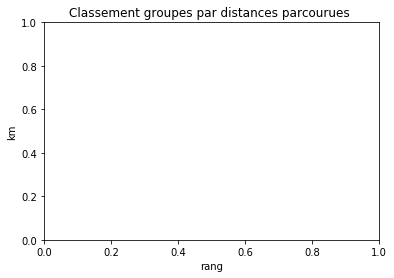

In [15]:


fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.set_title("Classement groupes par distances parcourues ")    
ax1.set_xlabel('rang')
ax1.set_ylabel('km')
ax1.plot(sorted(resultsGlobalYears,key=int),resultsGlobalYears[YearG]["toursGlobalLengthMAX"],'x' ,color='r', label="data['nom']")
ax1.set_autoscale_on
leg = ax1.legend()

plt.show()


In [55]:
with open("./tour_miner/"+"young-mc693097c4-17ec-4bb8-9b7c-74a5a2a85723"+".obj", 'rb') as handle:
    temp= pickle.load(handle)
    
print temp

{1: {'tourLength': 3, 'tourdist': 4412.095403569076, 'tourYear': 2013, 'tourdistOpt': 4412.095403569076}, 2: {'tourLength': 3, 'tourdist': 3598.3834783813863, 'tourYear': 2016, 'tourdistOpt': 3598.3834783813863}, 3: {'tourLength': 20, 'tourdist': 27289.99921420611, 'tourYear': 2016, 'tourdistOpt': 9304.647910861806}, 4: {'tourLength': 6, 'tourdist': 4892.130973463658, 'tourYear': 2016, 'tourdistOpt': 4892.130973463658}, 'name': u'Young MC', 6: {'tourLength': 8, 'tourdist': 7787.715648749957, 'tourYear': 2017, 'tourdistOpt': 6323.238414375028}, 7: {'tourLength': 31, 'tourdist': 73680.08716318749, 'tourYear': 2017, 'tourdistOpt': 46773.53267687943}, 8: {'tourLength': 4, 'tourdist': 2438.171813830467, 'tourYear': 2017, 'tourdistOpt': 2438.171813830467}, 9: {'tourLength': 10, 'tourdist': 16354.945789979454, 'tourYear': 2017, 'tourdistOpt': 10940.483749558794}, 10: {'tourLength': 8, 'tourdist': 8978.55589883757, 'tourYear': 2017, 'tourdistOpt': 15295.868189735194}, 'totalArtistOptTourDist':

In [6]:
with open("./RESULTSGLOBAL.obj", 'rb') as handle:
          temp= pickle.load( handle)
print temp

{'manOpt': 0.23255376595961377, 'autoOpt': 0.21995298276047787, 'totalOptDistsMin': 1639279100.4292355, 'totalOptDists': 1666194602.2991636, 'totalDists': 2136018170.0272305}


In [ ]:
***************************
TOTAL ARTISTS TOURS DISTS 2135250690.17
TOTAL AUTO OPTIMIZED ARTISTS TOURS DISTS 1665625398.71
TOTAL MANUALLY OPTIMIZED ARTISTS TOURS DISTS 1638787824.49
AUTO-OPTIMIZED BY  21.993918261  %
MANUALLY OPTIMIZED BY  23.2507999161  %
***************************

***************************
TOTAL ARTISTS TOURS DISTS 2136018170.03
TOTAL AUTO OPTIMIZED ARTISTS TOURS DISTS 1666994420.69
TOTAL MANUALLY OPTIMIZED ARTISTS TOURS DISTS 1640164490.57
AUTO-OPTIMIZED BY  21.9578539134  %
MANUALLY OPTIMIZED BY  23.2139260994  %
***************************
